# Covid Data Analysis Exercise

This is an exercise in using time-ordered data for regression analysis and forecasting. 

- `Datetime` library is a very useful module that makes it very easy to treat time stamps and plotting time ordered data.
- `Pandas`. We will use Pandas to handle data efficiently.

- Visit https://coronavirus.data.gov.uk/ to look at the available data.
- https://coronavirus.data.gov.uk/details/developers-guide/main-api explains the API interface. You will need to install the `uk_covid19` package. If this is not possible you can also download metrics individually using the website. 

# Exercise

- "Clean" the data of periodic systematics.

***Answer:*** I used "pd.concat" to combine  the df_google and df_england, and delected useless rows in the new created dataframe.

- Experiment using linear regression to create a model for covid metrics (time-lagged) with mobility metrics as covariates.

***Answer:*** In ***3.1 Method1: Multiple Linear Regression*** I used multi linear regression, created a model to fit the  relationship between the number of admissions and covariates.

- Can you use this model to "predict" covid severity?

A good starting point for this is the `sklearn` Linear Regression method https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html.
`sklearn` includes many other, more advanced methods, for cases where the space of covariates has large dimensions.

***Answer:*** In **3.1.Predictors** I built 4 models to predict the severity  and  compared the error of these models' prediction results between the real data in testsets.  

- Think about what data you use to calibrate your model.

***Answer:*** In each model I utilized 80% of time series data as trainset to train  the model and 20% of total data to test the model.

- Can you back test the data? 

***Answer:*** yes, I seperated  the data to trainset and testset, and utilized "root mean square error (rmse)" to test how the prediction result matches the real "y_test" value, actually this error is the loss functtion in the neural  network, which guides the model to minimize the loss and optimize the parametters inside the model. And I compared the results of different models.

- How well does your method work? What should you expect?

***Answer:*** In most cases the results were poor but LSTM method worked better than SVM, MLR and RFR. In one experiment the **root mean square errors of LSTM, SVM, MLR and RFR were 174.50, 500.61,  653.32, 596.67**, seperately. This result indicate that error of the LSTM methd is lower than  that of other methods. And the comparisons of the prediction results are shown in **3.2.Summary:Compare four methods.**

- Can you think of other data that could be used as covariates (predictors) or how to change this regression to make it work better?

***Answer:*** In **part4** I tried to change different metrices as covariates  and set a same neural network structure to test the RMS error in different kinds of covariances. The result showed that in LSTM model when we set **["grocery","parks" "workplaces"]** or **["parks", "transit", "workplaces", "residential"]**  as covariates, the model works best. The root mean square error of these two combinations are 171.06 and 170.14, respectively. When the mobility metrices are **["parks", "transit", and "workplaces"]**, the root mean square error is 172.74, which can also achieve good prediction for the training set.

# 1.Import necessary packages

In [1]:
!pip  install attention;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from attention import Attention
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler

In [3]:
import pandas as pd
import datetime as dt
import numpy as np

import matplotlib.pylab as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

#Show plots inline
%matplotlib inline

#Some date formatters to use for plotting 
weeks = mdates.WeekdayLocator()
years = mdates.YearLocator()
months = mdates.MonthLocator()
weekdays = mdates.DayLocator()
dateFmt = mdates.DateFormatter('%b-%y')

In [4]:
#seaborn is a useful package for handling graphics and 
#producing publication quality images with better colour schemes
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_context("talk")
#sns.set(font_scale=1.5) 
#sns.set_context("poster")

plt.rcParams.update({'font.size': 32})
plt.rcParams.update({'lines.linewidth':3})

# 2.Import UK COVID metrics

Next we can import the API package to download government covid metrics

Package install e.g.: `pip install uk-covid19`. If you are having trouble installing this I can provide the data.

This package is an interface to the UK government https://coronavirus.data.gov.uk/

We will use covid metrics as the dependent variables or outcomes in the regression problem.

In [5]:
!pip install uk_covid19;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from uk_covid19 import Cov19API

The following is an example download of covid cases, hospital occupancy and admissions, and deaths. You can query many othe metrics.

In [7]:
#Admin hierarchy of data (can also be regional and local)
areaType = 'nation'
area_filter = ['areaType={}'.format(areaType)]

#Form the API query
query = { "areaType":"areaType" ,"areaName":"areaName" ,"areaCode":"areaCode","specimenDate":"date"
         ,"dailyLabConfirmedCases":"newCasesBySpecimenDate","hospital":"hospitalCases"
         ,"newAdmissions":"newAdmissions","deaths":"newDeaths28DaysByDeathDate"
        }
api_query = Cov19API(filters=area_filter, structure=query)

#return a pandas dataframe. Other formats can be used e.g. JSON etc.
df = api_query.get_dataframe()

#rename columns
df.columns = ['Area type', 'Area name', 'Area code', 'Date', 'Cases','Hospital', 'Admissions', 'Deaths']
#Re-index by date
df.set_index(pd.to_datetime(df['Date'], format='%Y-%m-%d'),inplace=True)
df.sort_index(inplace=True)
df;

In [8]:
#Select just England data but Wales, Scoltand, and Northern Ireland can also be chosen
df_Eng = df[df['Area name']=='England'].copy()

For visualisation purposes it is often useful to take rolling averages of the noisy data.

- Add a 7-day rolling average of the hospital admissions column to the plot. See `DataFrame.rolling()` for a native method.

# 3.Predictors

In principle, covid cases, hospital admissions, and deaths are time-lagged outcomes of covariates or "predictor variables" such as the level of interactions in the population, mobility metrics, levels of restrictions etc.

A data set which is often used as a possible predictor is google mobility metrics https://www.google.com/covid19/mobility/.

In [9]:
#Import the data from Google.
#This is a large file!
df_google = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
#Select `United Kingdom` from the full data.
df_google = df_google[df_google['country_region']=='United Kingdom']
#Discard sub regions
#Note - we England vs UK
df_google = df_google[df_google['sub_region_1'].isnull()]

In [11]:
#Re-index by data
df_google.set_index(pd.to_datetime(df_google['date']),inplace=True)
df_google.sort_index(inplace=True)
df_google.columns

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

Plot up some of the metrics. 

How do they compare (correlate) against covid admissions?

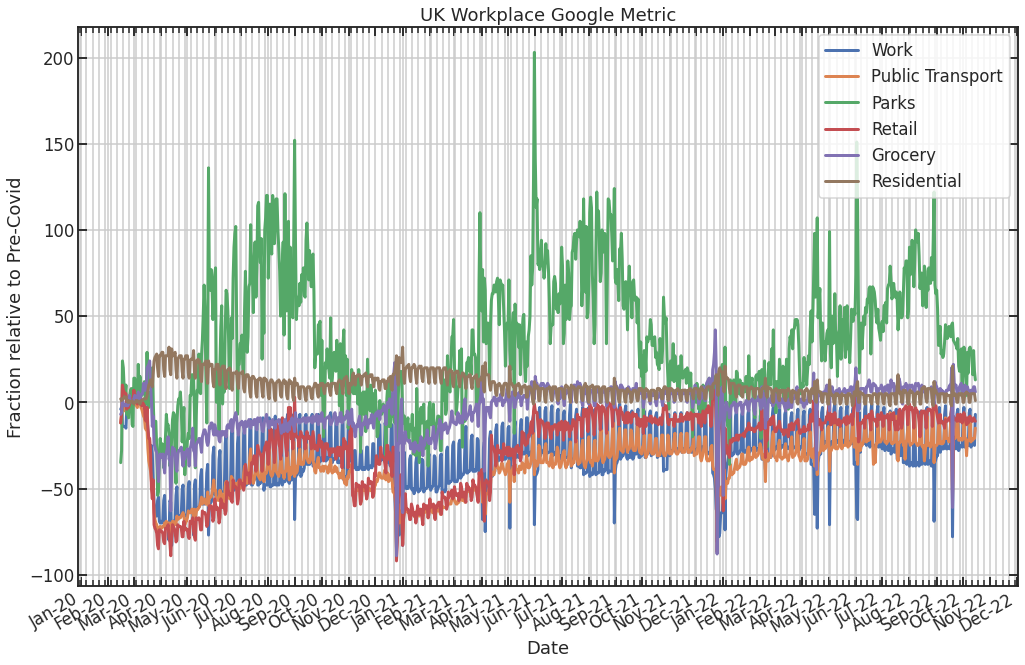

In [12]:
fig, ax = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')

ax.plot(df_google.index,df_google['workplaces_percent_change_from_baseline'],label='Work')
ax.plot(df_google.index,df_google['transit_stations_percent_change_from_baseline'],label='Public Transport')
ax.plot(df_google.index,df_google['parks_percent_change_from_baseline'],label='Parks')

ax.plot(df_google.index,df_google['retail_and_recreation_percent_change_from_baseline'],label='Retail')
ax.plot(df_google.index,df_google['grocery_and_pharmacy_percent_change_from_baseline'],label='Grocery')
ax.plot(df_google.index,df_google['residential_percent_change_from_baseline'],label='Residential')
#ax.scatter(df_Eng.index,df_Eng['Admissions'],label='Data',marker='.',c='C3')

ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)


ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Fraction relative to Pre-Covid')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
#ax.set_xlim(left=dt.datetime(2021,7,1))
ax.set_title('UK Workplace Google Metric')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('mobility.png')

In [13]:
print(df_Eng.index)

DatetimeIndex(['2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08',
               ...
               '2022-10-24', '2022-10-25', '2022-10-26', '2022-10-27',
               '2022-10-28', '2022-10-29', '2022-10-30', '2022-10-31',
               '2022-11-01', '2022-11-02'],
              dtype='datetime64[ns]', name='Date', length=1008, freq=None)


In [14]:
df1=df_Eng["2020-03-19":"2022-10-15"];

In [15]:
df2=df_google["2020-03-19":"2022-10-15"]

In [16]:
df_work=pd.concat([df1,df2],axis=1)

In [17]:
print(df_work.columns)

Index(['Area type', 'Area name', 'Area code', 'Date', 'Cases', 'Hospital',
       'Admissions', 'Deaths', 'country_region_code', 'country_region',
       'sub_region_1', 'sub_region_2', 'metro_area', 'iso_3166_2_code',
       'census_fips_code', 'place_id', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')


## 3.1.Four Methods

### Method1: Multiple Linear Regression

1. Import  necessary packagges.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

2. Import data and split data into  train and test  sets.

In [19]:
x_input3 = df_work[["workplaces_percent_change_from_baseline", "transit_stations_percent_change_from_baseline",
                "parks_percent_change_from_baseline"]].values

y_output3 = df_work[["Admissions"]].values

The prepocessor tool   in sklearn is helpful for the data normalization.

In  this model  I  set  the  normalization tool as "MinMaxScaler",    the   core concept of this tool is   to map   the data   to [0,1], or  use   the "feature_rangge"  to set  other ranges. In  small feature range, the weight of error is laeger   so in the training  peocess the model will change  the hyperparameters more and finally get a high   accuracy on   the test set and low loss function.

The calculation method in " MinMaxScaler" is shown below:
\begin{align}
  & Xstd=\frac{X-X.min(axis=0)}{X.max(axis=0)-X.min(axis=0)} \\ 
 & Xscaled=Xstd*(max-min)+min \\ 
\end{align}

"X.min(axis=0)" represents the row vector of the minimum values in each column, "X.max(axis=0)" represents row vector of maximum values in each column. "max" represents the maximum value of the interval to be mapped, (default is 1).
"min" represents the minimum value of the interval to be mapped, (default is 0)."Xstd" represents the standardized result.
"Xscaled" represents the normalized result.


In [20]:
sc = MinMaxScaler(feature_range=(0, 1))
sc_y = MinMaxScaler(feature_range=(0, 1))

x_input3 = sc.fit_transform(x_input3)
y_output3 = sc_y.fit_transform(y_output3)

I  set 80% of the time series data  to trainset to train the model and  20% of the time series data to testset to evaluate the model.

In [21]:
x_train3 = x_input3[0:int(len(x_input3) * 0.8)]
y_train3 = y_output3[0:int(len(y_output3) * 0.8)]
x_test3 = x_input3[int(len(x_input3) * 0.8):]
y_test3 = y_output3[int(len(y_output3) * 0.8):]

3. Create the model and carry out prediction

Multiple linear regression is used to estimate the relationship between two or more independent variables and a dependent variable. We use this method to calculate the value  of y (Admission number)  through determining  weights  of three varibles.

In [22]:
model3 = LinearRegression()
model3.fit(x_train3,y_train3)

LinearRegression()

In [23]:
prediction3 = model3.predict(x_test3)

4. Calculate the error

The Mean Squared Error (MSE) measures the amount of error in statistical models. And the The Root Mean Square Error (RMSE), also known as the standard error, is the arithmetic square root of the mean square error. 

In [24]:
prediction3=sc_y.inverse_transform(prediction3)
y_test3=sc_y.inverse_transform(y_test3)
def get_mse(real_value, predict_value):

    if len(real_value) == len(predict_value):
        return sum([(x - y) ** 2 for x, y in zip(real_value, predict_value)]) / len(real_value)
    else:
        return None
mse=get_mse(y_test3,prediction3)
rmse3=math.sqrt(mse)
print("The RMSE value of this MLR prediction task is {}.".format(rmse3))

The RMSE value of this MLR prediction task is 653.3255751872864.


5. Create a figure to visualize the data

In [25]:
df_prediction3 = pd.DataFrame(prediction3)
df_y_test3 = pd.DataFrame(y_test3)


In [26]:
df_y_test3=np.append(np.zeros(len(y_train3)),df_y_test3)
df_prediction3=np.append(np.zeros(len(y_train3)),df_prediction3)

In [27]:
df_work.insert(df_work.shape[1], "y_test3", df_y_test3)
df_work.insert(df_work.shape[1], "y_prediction3", df_prediction3)

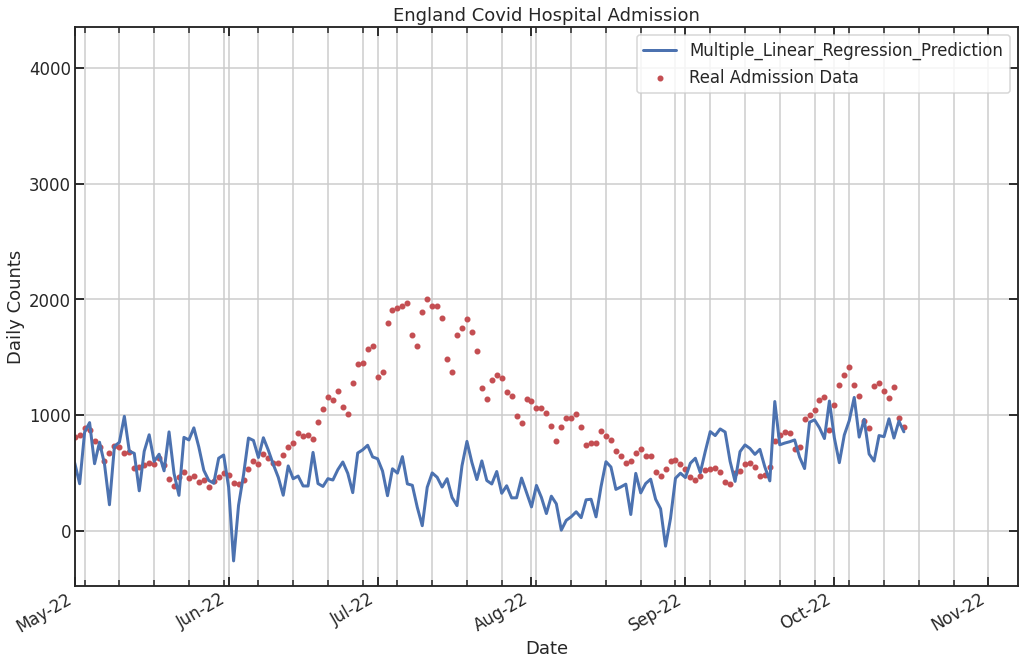

In [28]:
fig, ax = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')

ax.plot(df_work.index,df_work['y_prediction3'],label='Multiple_Linear_Regression_Prediction')
#ax.plot(df_google.index,df_google['workplaces_percent_change_from_baseline'],label='Work')
#ax.plot(df_google.index,df_google['transit_stations_percent_change_from_baseline'],label='Public Transport')
#ax.plot(df_google.index,df_google['parks_percent_change_from_baseline'],label='Parks')
ax.scatter(df_work.index,df_work['Admissions'],label='Real Admission Data',marker='.',c='C3')

ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)


ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Counts')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
ax.set_xlim(left=dt.datetime(2022,5,1),right=dt.datetime(2022,11,7))
ax.set_title('England Covid Hospital Admission')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('mobility.png')

### Method2: Support Vector Machine

1. Import data and split data into trainset and testset

In [29]:
x_input1 = df_work[["workplaces_percent_change_from_baseline", "transit_stations_percent_change_from_baseline",
                "parks_percent_change_from_baseline"]].values
print(x_input1.shape)
y_output1 = df_work[["Admissions"]].values

(941, 3)


In [30]:
sc = MinMaxScaler(feature_range=(0, 1))
sc_y = MinMaxScaler(feature_range=(0, 1))

x_input1 = sc.fit_transform(x_input1)
y_output1 = sc_y.fit_transform(y_output1)

In [31]:
x_train1 = x_input1[0:int(len(x_input1) * 0.8)]
y_train1 = y_output1[0:int(len(y_output1) * 0.8)]
x_test1 = x_input1[int(len(x_input1) * 0.8):]
y_test1 = y_output1[int(len(y_output1) * 0.8):]

2. Create the model and carry out prediction

In this part I selected the SVR methods among  all SVM models in "sklearn.svm". Even though in large datasets  "LinearSVR"  or "SGDRegressor" are more effective, in this small dataset  it's no need to consider much  of the computational efficiency.

Two free parameters  in SVR are: C and epailon. C  is the regularization  parameter and here we set it as 1 (default value). epsilon represents the distance between the  f(x) and  y, when the distance  is larger than epsilon, it calculated the loss. We set it 0.1.

The model is optimized by maximizing the width of the spacer band and minimizing the total loss, which is different from the  general linear regression which optimize the model by averaging after gradient descent.

In [33]:
from sklearn import svm
regr = svm.SVR()
regr.fit(x_train1,y_train1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [34]:
prediction1=regr.predict(x_test1)
prediction1=prediction1.reshape(-1,1)

In [35]:
prediction1=sc_y.inverse_transform(prediction1)
y_test1=sc_y.inverse_transform(y_test1)

3. Calculate the error

In [36]:
def get_mse(real_value, predict_value):

    if len(real_value) == len(predict_value):
        return sum([(x - y) ** 2 for x, y in zip(real_value, predict_value)]) / len(real_value)
    else:
        return None

mse1=get_mse(prediction1,y_test1)
rmse1=math.sqrt(mse1)
print("The RMSE value of this SVM prediction task is {}.".format(rmse1))

The RMSE value of this SVM prediction task is 500.6087131653999.


4. Create a figure to visualize the data

In [37]:
df_prediction1 = pd.DataFrame(prediction1)
df_y_test1 = pd.DataFrame(y_test1)


In [38]:
df_y_test1=np.append(np.zeros(len(y_train1)),df_y_test1)
df_prediction1=np.append(np.zeros(len(y_train1)),df_prediction1)

In [39]:
df_work.insert(df_work.shape[1], "y_test1", df_y_test1)
df_work.insert(df_work.shape[1], "y_prediction1", df_prediction1)

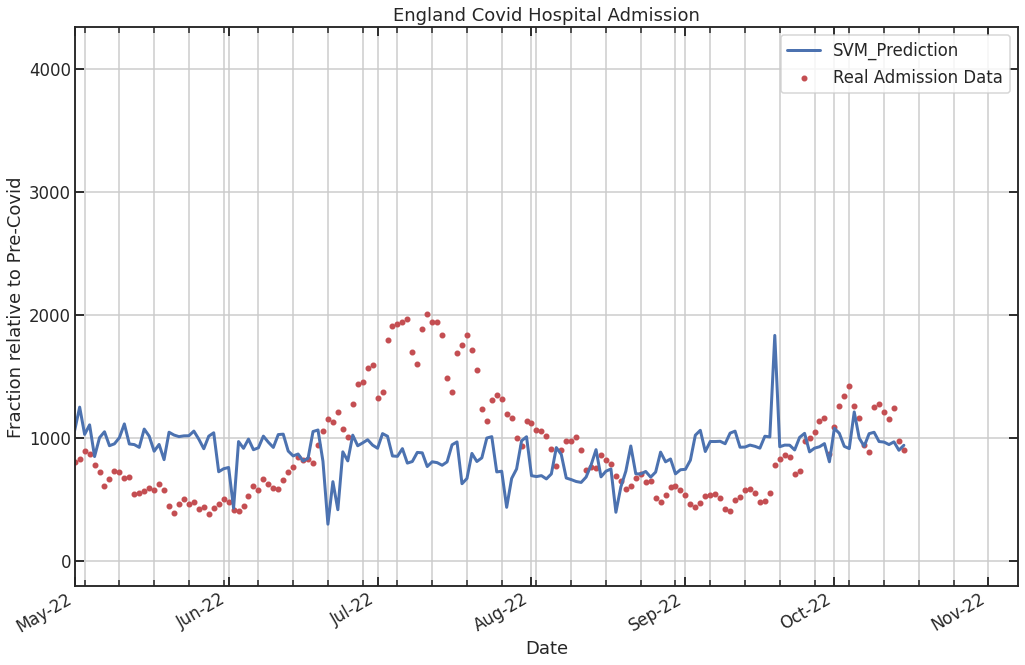

In [130]:
fig, ax = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')

ax.plot(df_work.index,df_work['y_prediction1'],label='SVM_Prediction')
#ax.plot(df_google.index,df_google['workplaces_percent_change_from_baseline'],label='Work')
#ax.plot(df_google.index,df_google['transit_stations_percent_change_from_baseline'],label='Public Transport')
#ax.plot(df_google.index,df_google['parks_percent_change_from_baseline'],label='Parks')
ax.scatter(df_work.index,df_work['Admissions'],label='Real Admission Data',marker='.',c='C3')

ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)


ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Fraction relative to Pre-Covid')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
ax.set_xlim(left=dt.datetime(2022,5,1),right=dt.datetime(2022,11,7))
ax.set_title('England Covid Hospital Admission')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('mobility.png')

###Method3: Random  Forests Regression

1. Import  necessary packagges.

In [41]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


2. Import data and split data into train and test sets.

In [42]:
x_input4 = df_work[["workplaces_percent_change_from_baseline", "transit_stations_percent_change_from_baseline",
                "parks_percent_change_from_baseline"]].values

y_output4 = df_work[["Admissions"]].values

In [43]:
sc = MinMaxScaler(feature_range=(0, 1))
sc_y = MinMaxScaler(feature_range=(0, 1))
x_input4 = sc.fit_transform(x_input4)
y_output4 = sc_y.fit_transform(y_output4)

In [44]:
x_train4 = x_input4[0:int(len(x_input4) * 0.8)]
y_train4 = y_output4[0:int(len(y_output4) * 0.8)]
x_test4 = x_input4[int(len(x_input4) * 0.8):]
y_test4 = y_output4[int(len(y_output4) * 0.8):]

3. Set the  model and carry out prediction

In [45]:
forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse',
                               random_state=1,
                               n_jobs=-1)

In [46]:
forest.fit(x_train4, y_train4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RandomForestRegressor(criterion='mse', n_estimators=1000, n_jobs=-1,
                      random_state=1)

In [47]:
prediction4 = forest.predict(x_test4)
#y_test4 = forest.predict(x_test4)

4. Calculate  the  error

In [48]:
prediction4=prediction4.reshape(-1,1)
prediction4=sc_y.inverse_transform(prediction4)
y_test4=sc_y.inverse_transform(y_test4)
def get_mse(real_value, predict_value):

    if len(real_value) == len(predict_value):
        return sum([(x - y) ** 2 for x, y in zip(real_value, predict_value)]) / len(real_value)
    else:
        return None
mse=get_mse(y_test4,prediction4)
rmse4=math.sqrt(mse)
print("The RMSE value of this RFR prediction task is {}.".format(rmse4))

The RMSE value of this MLR prediction task is 596.6775343753599.


5. Plot a figure  and visulaze  the  data

In [49]:
df_prediction4 = pd.DataFrame(prediction4)
df_y_test4 = pd.DataFrame(y_test4)
df_y_test4=np.append(np.zeros(len(y_train4)),df_y_test4)
df_prediction4=np.append(np.zeros(len(y_train4)),df_prediction4)
df_work.insert(df_work.shape[1], "y_test4", df_y_test4)
df_work.insert(df_work.shape[1], "y_prediction4", df_prediction4)

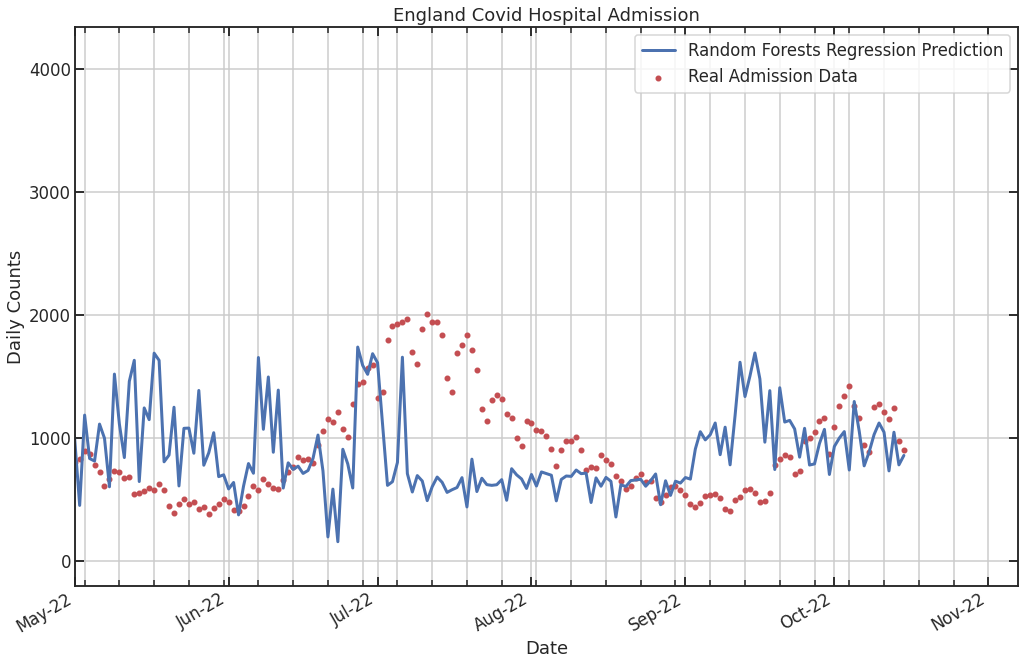

In [50]:
fig, ax = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')

ax.plot(df_work.index,df_work['y_prediction4'],label='Random Forests Regression Prediction')
#ax.plot(df_google.index,df_google['workplaces_percent_change_from_baseline'],label='Work')
#ax.plot(df_google.index,df_google['transit_stations_percent_change_from_baseline'],label='Public Transport')
#ax.plot(df_google.index,df_google['parks_percent_change_from_baseline'],label='Parks')
ax.scatter(df_work.index,df_work['Admissions'],label='Real Admission Data',marker='.',c='C3')

ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)


ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Counts')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
ax.set_xlim(left=dt.datetime(2022,5,1),right=dt.datetime(2022,11,7))
ax.set_title('England Covid Hospital Admission')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('mobility.png')

### Method4: Long Short Term Memory neural network

In [51]:
x_input2 = df_work[["workplaces_percent_change_from_baseline", "transit_stations_percent_change_from_baseline",
                "parks_percent_change_from_baseline","Admissions"]].values
print(x_input2.shape)
y_output2 = df_work[["Admissions"]].values

(941, 4)


In [52]:
sc = MinMaxScaler(feature_range=(0, 1))
sc_y = MinMaxScaler(feature_range=(0, 1))

x_input2 = sc.fit_transform(x_input2)
y_output2 = sc_y.fit_transform(y_output2)

dbx = []
dby = []

time_step = 5
for i in range(time_step, x_input2.shape[0]):
    dbx.append(x_input2[i - time_step:i, :])
    dby.append(y_output2[i])

dbx = np.array(dbx)
dby = np.array(dby)

ls = dbx.shape[0]

x_train2 = dbx[0:int(ls * 0.8)]
y_train2 = dby[0:int(ls * 0.8)]
x_test2 = dbx[int(ls * 0.8):]
y_test2 = dby[int(ls * 0.8):]


In [53]:

np.random.seed(116)
np.random.shuffle(x_train2)
np.random.seed(116)
np.random.shuffle(y_train2)

x_train2 = np.reshape(x_train2, (x_train2.shape[0], 5, 4))
x_test2 = np.reshape(x_test2, (x_test2.shape[0], 5, 4))

model = tf.keras.Sequential([
    LSTM(100, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(100, activation='tanh', return_sequences=True),
    Dropout(0.2),
    Attention(),
    tf.keras.layers.Flatten(),
    Dense(80, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_squared_error')

model.fit(x_train2, y_train2, epochs=20, batch_size=100)
model.summary()

Epoch 1/20
8/8 [==============================] - 6s 33ms/step - loss: 0.0525
Epoch 2/20
8/8 [==============================] - 0s 34ms/step - loss: 0.0165
Epoch 3/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0068
Epoch 4/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0039
Epoch 5/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0035
Epoch 6/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0033
Epoch 7/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0028
Epoch 8/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0026
Epoch 9/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0027
Epoch 10/20
8/8 [==============================] - 0s 35ms/step - loss: 0.0024
Epoch 11/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0025
Epoch 12/20
8/8 [==============================] - 0s 35ms/step - loss: 0.0028
Epoch 13/20
8/8 [==============================] - 0s 31ms/st

By adding the dropout layer each batch  of  the  training  data is randomly selected and the location of weights randomly ignored in different sub-neuralnetworks are different. In another word the model trained multiple sub_neuralnetworks. Finally during  the test process these small subnetworks are combined together. This  method can effectively avoid overfitting.

The first parameter  in LSTM layer is "100", which  represents the output dimension is  100. The "return_sequences" is set as "True" because the  layer returns the whold sequence rather thanthe last  output of this sequence. Adding an attention layer can make  better use    of important information  to do prediction.

In  the dense layer, the "out"  is the sum of "Activation(Input Kernel)"  and  "Bias".  The  avtivation  here is  set as "relu" and the  number of neural in this layer is set as 80. The number of parameters in  this  layer is the number of neurals  in   the  last layer  (128)  multiplies the number of  neurals in this layer plus the number   of layers in  this layers.

In [54]:
x_test2 = np.reshape(x_test2, (x_test2.shape[0], 5, 4))
y_test2 = dby[int(ls * 0.8):]
prediction2 = model.predict(x_test2)

6/6 [==============================] - 1s 5ms/step


In [55]:
prediction2=sc_y.inverse_transform(prediction2)
y_test2=sc_y.inverse_transform(y_test2)
def get_mse(real_value, predict_value):

    if len(real_value) == len(predict_value):
        return sum([(x - y) ** 2 for x, y in zip(real_value, predict_value)]) / len(real_value)
    else:
        return None
mse=get_mse(y_test2,prediction2)
rmse2=math.sqrt(mse)
print("The RMSE value of this LSTM prediction task is {}.".format(rmse2))

The RMSE value of this LSTM prediction task is 183.24024205881025.


In [56]:
df_prediction2 = pd.DataFrame(prediction2)
df_y_test2 = pd.DataFrame(y_test2)
pre0=np.zeros(len(y_train2)+5)
pre01=np.zeros(len(y_train2))
pre02=np.zeros(5)
df_y_test2=np.append(pre0,df_y_test2)
#df_y_test2=np.append(df_y_test2,pre02)
df_prediction2=np.append(pre0,df_prediction2)
#df_prediction2=np.append(df_prediction2,pre02)

In [57]:
#df_work=df_work.drop(columns=["y_test2","y_prediction2"])

In [58]:
df_work.insert(df_work.shape[1], "y_test2", df_y_test2)
df_work.insert(df_work.shape[1], "y_prediction2", df_prediction2)

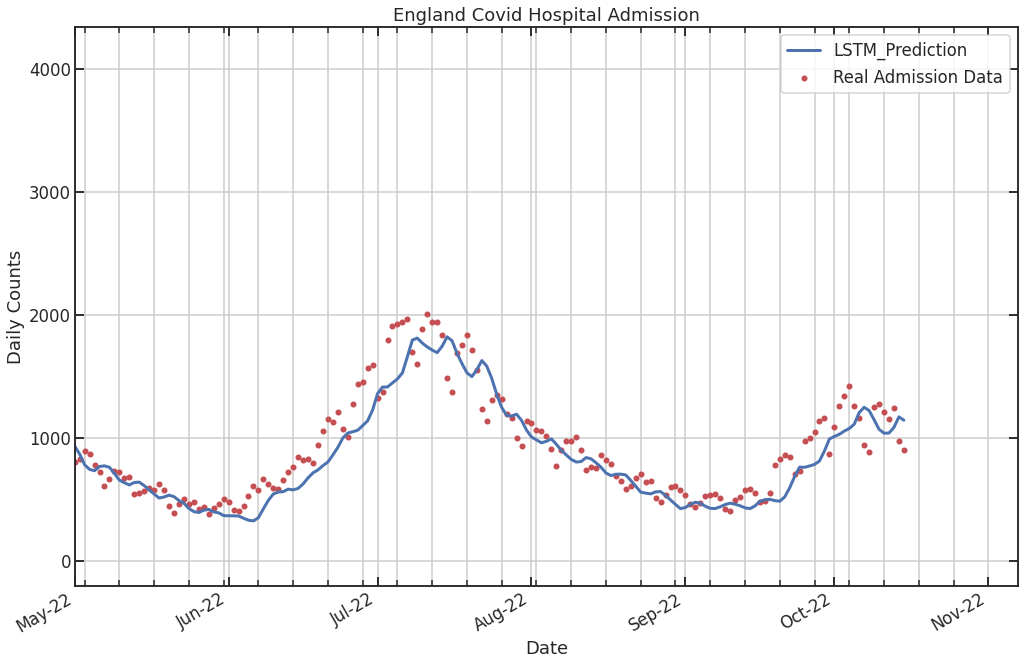

In [59]:
fig, ax = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')

ax.plot(df_work.index,df_work['y_prediction2'],label='LSTM_Prediction')
#ax.plot(df_google.index,df_google['workplaces_percent_change_from_baseline'],label='Work')
#ax.plot(df_google.index,df_google['transit_stations_percent_change_from_baseline'],label='Public Transport')
#ax.plot(df_google.index,df_google['parks_percent_change_from_baseline'],label='Parks')
ax.scatter(df_work.index,df_work['Admissions'],label='Real Admission Data',marker='.',c='C3')

ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)


ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Counts')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
ax.set_xlim(left=dt.datetime(2022,5,1),right=dt.datetime(2022,11,7))
ax.set_title('England Covid Hospital Admission')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('mobility.png')

##3.2.Summary: Compare  four methods

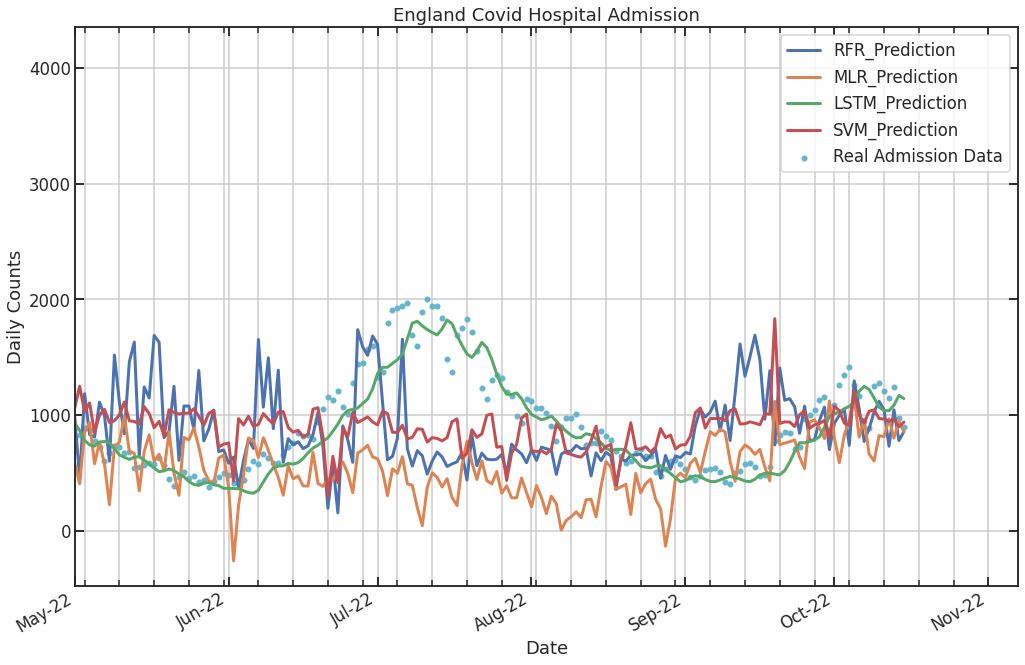

In [60]:
fig, ax = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')

ax.plot(df_work.index,df_work['y_prediction4'],label='RFR_Prediction')
ax.plot(df_work.index,df_work['y_prediction3'],label='MLR_Prediction')
ax.plot(df_work.index,df_work['y_prediction2'],label='LSTM_Prediction')
ax.plot(df_work.index,df_work['y_prediction1'],label='SVM_Prediction')

ax.scatter(df_work.index,df_work['Admissions'],label='Real Admission Data',marker='.',c='C9')
#ax.scatter(df_Eng.index,df_Eng['Admissions'],label='Data',marker='.',c='C3')
ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)


ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Counts')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
ax.set_xlim(left=dt.datetime(2022,5,1),right=dt.datetime(2022,11,7))
ax.set_title('England Covid Hospital Admission')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('mobility.png')

In one experiment the RMSE value of  these four methods are: E_MLR=653.33,E_SVM=500.61,E_RFR=596.68,E_LSTM=183.24, seperately. So the LSTM works  better in  this  task.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


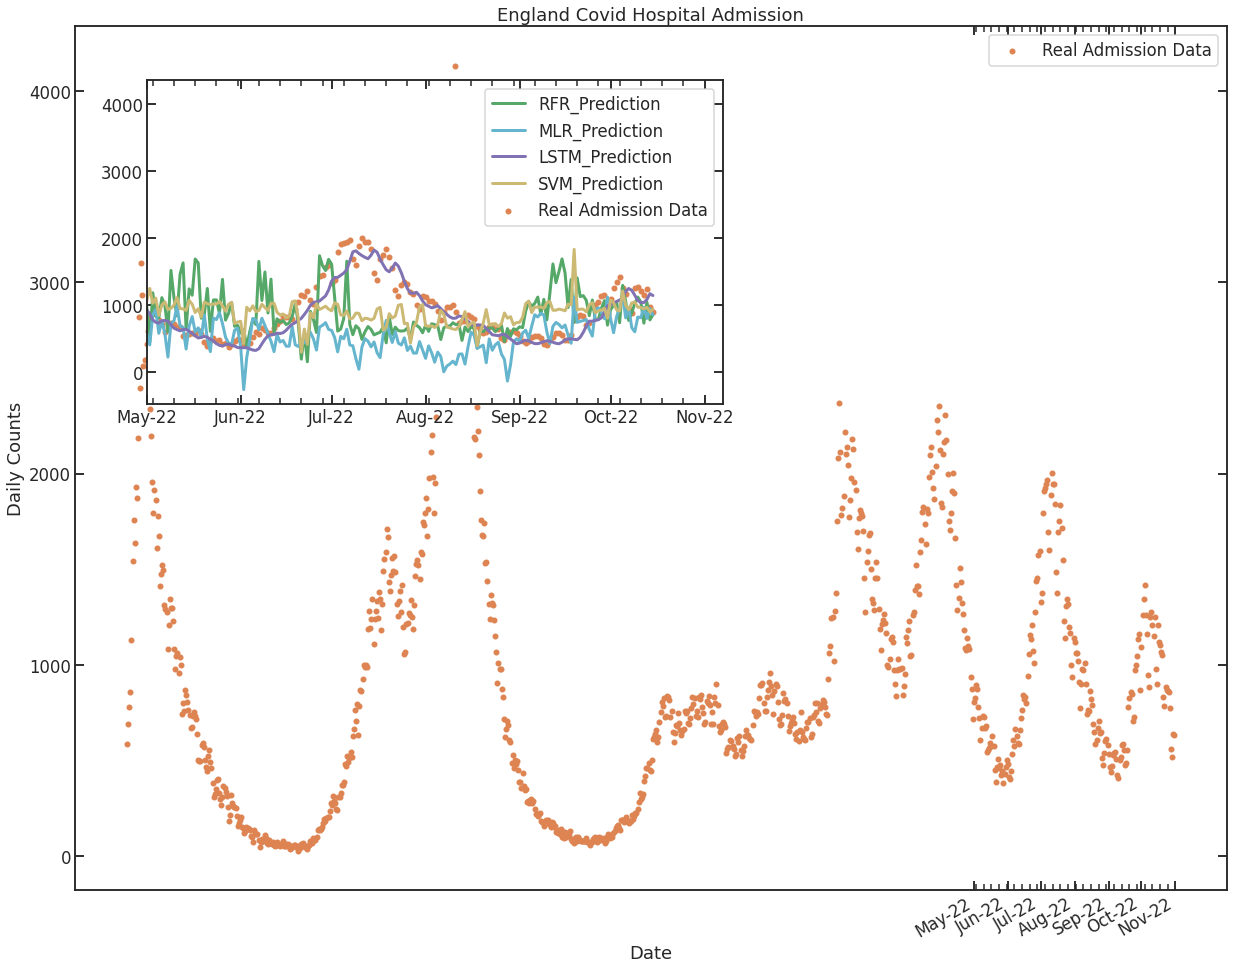

In [142]:
import numpy as np
import pylab as pl
pl.rcParams['figure.figsize'] = [20, 15] 

fig=pl.figure("New Figure")

ax=fig.add_axes([0.05, 0.1, 0.8, 0.8]) # [x0,y0,width,height]
#ax.scatter(df_work.index,df_work['Admissions'],label='Real Data',marker='.',c='C9')
ax.scatter(df_Eng.index,df_Eng['Admissions'],label='Real Admission Data',marker='.',c='C1')
ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)


#ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Counts')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
#ax.set_xlim(left=dt.datetime(2022,5,1),right=dt.datetime(2022,11,7))
ax.set_title('England Covid Hospital Admission')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()

#ax1=fig.add_axes([.43, .55, .4, .3]) # [x0,y0,width,height]
ax1=fig.add_axes([.1, .55, .4, .3]) # [x0,y0,width,height]
ax1.plot(df_work.index,df_work['y_prediction4'],label='RFR_Prediction',c='C2')
ax1.plot(df_work.index,df_work['y_prediction3'],label='MLR_Prediction',c='C9')
ax1.plot(df_work.index,df_work['y_prediction2'],label='LSTM_Prediction',c='C4')
ax1.plot(df_work.index,df_work['y_prediction1'],label='SVM_Prediction',c='C8')

ax1.scatter(df_work.index,df_work['Admissions'],label='Real Admission Data',marker='.',c='C1')

ax1.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)



#ax1.set_xlabel('Date')
#ax1.set_ylabel('Daily Counts')

# format the ticks
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(dateFmt)
ax1.xaxis.set_minor_locator(weeks)
ax1.set_xlim(left=dt.datetime(2022,5,1),right=dt.datetime(2022,11,7))
#ax1.set_title('England Covid Hospital Admission')
ax1.legend()

_= fig.autofmt_xdate()



pl.savefig("inset_plots.png")

pl.tight_layout()
pl.show()

We   use 80%  of the time series data to  train the model and  use 20% of the time series data to test the model.  This figure    shows the real "Admission" data  in the whole time series, and the  predicted data in  the last   20% time series.

# 4.Compare different mobility  metrices as covariates

## 4.1.LSTM

The goal of this part is to select the most useful combination of  metrices to calibrate my LSTM model.

Seven metrices available are:

["retail", "grocery", "parks", "transit", "workplaces", "residential"],and we use  ["1","2","3","4","5","6"]  to represent them,  seperately. Another necessary covariates in LSTM is "Admissions"(5 days'data  before the prediction goal time).

In [62]:
rmse_compare=[]

### 4.1,1.LSTM1 (4 mobility metrices as covariates included)

In [63]:
def LSTM1(x_input2,y_output2):

  sc = MinMaxScaler(feature_range=(0, 1))
  sc_y = MinMaxScaler(feature_range=(0, 1))
  x_input2 = sc.fit_transform(x_input2)
  y_output2 = sc_y.fit_transform(y_output2)
  dbx = []
  dby = []
  time_step = 5
  for i in range(time_step, x_input2.shape[0]):
    dbx.append(x_input2[i - time_step:i, :])
    dby.append(y_output2[i])

  dbx = np.array(dbx)
  dby = np.array(dby)
  ls = dbx.shape[0]
  x_train2 = dbx[0:int(ls * 0.8)]
  y_train2 = dby[0:int(ls * 0.8)]
  x_test2 = dbx[int(ls * 0.8):]
  y_test2 = dby[int(ls * 0.8):]
  np.random.seed(116)
  np.random.shuffle(x_train2)
  np.random.seed(116)
  np.random.shuffle(y_train2)

  x_train2 = np.reshape(x_train2, (x_train2.shape[0], 5, 4))
  x_test2 = np.reshape(x_test2, (x_test2.shape[0], 5, 4))

  model = tf.keras.Sequential([
     LSTM(100, activation='tanh', return_sequences=True),
     Dropout(0.2),
     LSTM(100, activation='tanh', return_sequences=True),
     Dropout(0.2),
     Attention(),
     tf.keras.layers.Flatten(),
     Dense(80, activation='relu'),
     Dense(1)
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_squared_error')

  model.fit(x_train2, y_train2, epochs=20, batch_size=100)
  model.summary()
  x_test2 = np.reshape(x_test2, (x_test2.shape[0], 5, 4))
  y_test2 = dby[int(ls * 0.8):]
  prediction2 = model.predict(x_test2)
  prediction2=sc_y.inverse_transform(prediction2)
  y_test2=sc_y.inverse_transform(y_test2)
  def get_mse(real_value, predict_value):

     if len(real_value) == len(predict_value):
         return sum([(x - y) ** 2 for x, y in zip(real_value, predict_value)]) / len(real_value)
     else:
         return None
  mse=get_mse(y_test2,prediction2)
  rmse2=math.sqrt(mse)
  rmse_compare.append(rmse2)
  print("The RMSE value of this LSTM prediction task is {}.".format(rmse2))


In [64]:
x_input123 = df_work[["retail_and_recreation_percent_change_from_baseline", 
            "grocery_and_pharmacy_percent_change_from_baseline",
            "parks_percent_change_from_baseline",
            "Admissions"]].values
y_output123 = df_work[["Admissions"]].values
LSTM1(x_input123,y_output123)

Epoch 1/20
8/8 [==============================] - 5s 43ms/step - loss: 0.0526
Epoch 2/20
8/8 [==============================] - 0s 39ms/step - loss: 0.0177
Epoch 3/20
8/8 [==============================] - 0s 43ms/step - loss: 0.0069
Epoch 4/20
8/8 [==============================] - 0s 46ms/step - loss: 0.0042
Epoch 5/20
8/8 [==============================] - 0s 42ms/step - loss: 0.0040
Epoch 6/20
8/8 [==============================] - 0s 37ms/step - loss: 0.0031
Epoch 7/20
8/8 [==============================] - 0s 40ms/step - loss: 0.0032
Epoch 8/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0028
Epoch 9/20
8/8 [==============================] - 0s 40ms/step - loss: 0.0030
Epoch 10/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0029
Epoch 11/20
8/8 [==============================] - 0s 34ms/step - loss: 0.0031
Epoch 12/20
8/8 [==============================] - 0s 36ms/step - loss: 0.0024
Epoch 13/20
8/8 [==============================] - 0s 34ms/st

In [65]:
x_input124 = df_work[["retail_and_recreation_percent_change_from_baseline", 
            "grocery_and_pharmacy_percent_change_from_baseline",
            "transit_stations_percent_change_from_baseline",
            "Admissions"]].values
y_output124 = df_work[["Admissions"]].values
LSTM1(x_input124,y_output124)

Epoch 1/20
8/8 [==============================] - 5s 32ms/step - loss: 0.0606
Epoch 2/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0204
Epoch 3/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0072
Epoch 4/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0045
Epoch 5/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0038
Epoch 6/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0030
Epoch 7/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0028
Epoch 8/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0027
Epoch 9/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0029
Epoch 10/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0029
Epoch 11/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0025
Epoch 12/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0029
Epoch 13/20
8/8 [==============================] - 0s 31ms/st

In [66]:
x_input125 = df_work[["retail_and_recreation_percent_change_from_baseline", 
            "grocery_and_pharmacy_percent_change_from_baseline",
            "workplaces_percent_change_from_baseline",
            "Admissions"]].values
y_output125 = df_work[["Admissions"]].values
LSTM1(x_input125,y_output125)

Epoch 1/20
8/8 [==============================] - 6s 79ms/step - loss: 0.0520
Epoch 2/20
8/8 [==============================] - 1s 69ms/step - loss: 0.0168
Epoch 3/20
8/8 [==============================] - 1s 75ms/step - loss: 0.0077
Epoch 4/20
8/8 [==============================] - 1s 68ms/step - loss: 0.0054
Epoch 5/20
8/8 [==============================] - 1s 98ms/step - loss: 0.0044
Epoch 6/20
8/8 [==============================] - 0s 62ms/step - loss: 0.0039
Epoch 7/20
8/8 [==============================] - 1s 56ms/step - loss: 0.0031
Epoch 8/20
8/8 [==============================] - 0s 59ms/step - loss: 0.0029
Epoch 9/20
8/8 [==============================] - 1s 67ms/step - loss: 0.0026
Epoch 10/20
8/8 [==============================] - 1s 65ms/step - loss: 0.0027
Epoch 11/20
8/8 [==============================] - 1s 67ms/step - loss: 0.0026
Epoch 12/20
8/8 [==============================] - 1s 61ms/step - loss: 0.0028
Epoch 13/20
8/8 [==============================] - 1s 73ms/st

In [67]:
x_input126 = df_work[["retail_and_recreation_percent_change_from_baseline", 
            "grocery_and_pharmacy_percent_change_from_baseline",
            "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output126 = df_work[["Admissions"]].values
LSTM1(x_input126,y_output126)

Epoch 1/20
8/8 [==============================] - 9s 31ms/step - loss: 0.0461
Epoch 2/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0148
Epoch 3/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0067
Epoch 4/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0045
Epoch 5/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0040
Epoch 6/20
8/8 [==============================] - 0s 28ms/step - loss: 0.0033
Epoch 7/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0037
Epoch 8/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0031
Epoch 9/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0029
Epoch 10/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0029
Epoch 11/20
8/8 [==============================] - 0s 29ms/step - loss: 0.0027
Epoch 12/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0027
Epoch 13/20
8/8 [==============================] - 0s 30ms/st

In [68]:
x_input234 = df_work[["grocery_and_pharmacy_percent_change_from_baseline",
 "parks_percent_change_from_baseline",
 "transit_stations_percent_change_from_baseline",
            "Admissions"]].values
y_output234 = df_work[["Admissions"]].values
LSTM1(x_input234,y_output234)

Epoch 1/20
8/8 [==============================] - 5s 30ms/step - loss: 0.0540
Epoch 2/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0159
Epoch 3/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0064
Epoch 4/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0037
Epoch 5/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0041
Epoch 6/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0034
Epoch 7/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0030
Epoch 8/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0029
Epoch 9/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0027
Epoch 10/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0030
Epoch 11/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0031
Epoch 12/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0028
Epoch 13/20
8/8 [==============================] - 0s 29ms/st

In [69]:
x_input235 = df_work[["grocery_and_pharmacy_percent_change_from_baseline",
 "parks_percent_change_from_baseline",
 "workplaces_percent_change_from_baseline",
            "Admissions"]].values
y_output235 = df_work[["Admissions"]].values
LSTM1(x_input235,y_output235)

Epoch 1/20
8/8 [==============================] - 6s 31ms/step - loss: 0.0572
Epoch 2/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0192
Epoch 3/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0061
Epoch 4/20
8/8 [==============================] - 0s 36ms/step - loss: 0.0043
Epoch 5/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0037
Epoch 6/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0030
Epoch 7/20
8/8 [==============================] - 0s 34ms/step - loss: 0.0031
Epoch 8/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0026
Epoch 9/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0029
Epoch 10/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0026
Epoch 11/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0026
Epoch 12/20
8/8 [==============================] - 0s 34ms/step - loss: 0.0026
Epoch 13/20
8/8 [==============================] - 0s 31ms/st

In [70]:
x_input236 = df_work[["grocery_and_pharmacy_percent_change_from_baseline",
 "parks_percent_change_from_baseline",
 "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output236 = df_work[["Admissions"]].values
LSTM1(x_input236,y_output236)

Epoch 1/20
8/8 [==============================] - 5s 31ms/step - loss: 0.0448
Epoch 2/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0159
Epoch 3/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0068
Epoch 4/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0036
Epoch 5/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0036
Epoch 6/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0032
Epoch 7/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0031
Epoch 8/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0029
Epoch 9/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0028
Epoch 10/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0026
Epoch 11/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0030
Epoch 12/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0025
Epoch 13/20
8/8 [==============================] - 0s 32ms/st

In [71]:
x_input345 = df_work[["parks_percent_change_from_baseline",
 "transit_stations_percent_change_from_baseline",
 "workplaces_percent_change_from_baseline",
            "Admissions"]].values
y_output345 = df_work[["Admissions"]].values
LSTM1(x_input345,y_output345)

Epoch 1/20
8/8 [==============================] - 6s 33ms/step - loss: 0.0465
Epoch 2/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0115
Epoch 3/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0069
Epoch 4/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0045
Epoch 5/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0039
Epoch 6/20
8/8 [==============================] - 0s 34ms/step - loss: 0.0035
Epoch 7/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0033
Epoch 8/20
8/8 [==============================] - 0s 35ms/step - loss: 0.0028
Epoch 9/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0029
Epoch 10/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0028
Epoch 11/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0027
Epoch 12/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0031
Epoch 13/20
8/8 [==============================] - 0s 33ms/st

In [72]:
x_input346 = df_work[["parks_percent_change_from_baseline",
 "transit_stations_percent_change_from_baseline",
            "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output346 = df_work[["Admissions"]].values
LSTM1(x_input346,y_output346)

Epoch 1/20
8/8 [==============================] - 7s 33ms/step - loss: 0.0489
Epoch 2/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0151
Epoch 3/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0068
Epoch 4/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0042
Epoch 5/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0032
Epoch 6/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0025
Epoch 7/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0029
Epoch 8/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0024
Epoch 9/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0028
Epoch 10/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0025
Epoch 11/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0032
Epoch 12/20
8/8 [==============================] - 0s 34ms/step - loss: 0.0029
Epoch 13/20
8/8 [==============================] - 0s 33ms/st

In [73]:
x_input456 = df_work[["transit_stations_percent_change_from_baseline",
 "workplaces_percent_change_from_baseline",
 "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output456 = df_work[["Admissions"]].values
LSTM1(x_input456,y_output456)

Epoch 1/20
8/8 [==============================] - 6s 35ms/step - loss: 0.0495
Epoch 2/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0215
Epoch 3/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0091
Epoch 4/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0045
Epoch 5/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0040
Epoch 6/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0031
Epoch 7/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0029
Epoch 8/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0029
Epoch 9/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0028
Epoch 10/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0026
Epoch 11/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0026
Epoch 12/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0027
Epoch 13/20
8/8 [==============================] - 0s 32ms/st

### 4.1.2.LSTM2 (5 mobility metrices as covariates included)

In [74]:
def LSTM2(x_input2,y_output2):

  sc = MinMaxScaler(feature_range=(0, 1))
  sc_y = MinMaxScaler(feature_range=(0, 1))
  x_input2 = sc.fit_transform(x_input2)
  y_output2 = sc_y.fit_transform(y_output2)
  dbx = []
  dby = []
  time_step = 5
  for i in range(time_step, x_input2.shape[0]):
    dbx.append(x_input2[i - time_step:i, :])
    dby.append(y_output2[i])

  dbx = np.array(dbx)
  dby = np.array(dby)
  ls = dbx.shape[0]
  x_train2 = dbx[0:int(ls * 0.8)]
  y_train2 = dby[0:int(ls * 0.8)]
  x_test2 = dbx[int(ls * 0.8):]
  y_test2 = dby[int(ls * 0.8):]
  np.random.seed(116)
  np.random.shuffle(x_train2)
  np.random.seed(116)
  np.random.shuffle(y_train2)

  x_train2 = np.reshape(x_train2, (x_train2.shape[0], 5, 5))
  x_test2 = np.reshape(x_test2, (x_test2.shape[0], 5, 5))

  model = tf.keras.Sequential([
     LSTM(100, activation='tanh', return_sequences=True),
     Dropout(0.2),
     LSTM(100, activation='tanh', return_sequences=True),
     Dropout(0.2),
     Attention(),
     tf.keras.layers.Flatten(),
     Dense(80, activation='relu'),
     Dense(1)
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_squared_error')

  model.fit(x_train2, y_train2, epochs=20, batch_size=100)
  model.summary()
  x_test2 = np.reshape(x_test2, (x_test2.shape[0], 5, 5))
  y_test2 = dby[int(ls * 0.8):]
  prediction2 = model.predict(x_test2)
  prediction2=sc_y.inverse_transform(prediction2)
  y_test2=sc_y.inverse_transform(y_test2)
  def get_mse(real_value, predict_value):

     if len(real_value) == len(predict_value):
         return sum([(x - y) ** 2 for x, y in zip(real_value, predict_value)]) / len(real_value)
     else:
         return None
  mse=get_mse(y_test2,prediction2)
  rmse2=math.sqrt(mse)
  rmse_compare.append(rmse2)
  print("The RMSE value of this LSTM prediction task is {}.".format(rmse2))

In [75]:
x_input1234 = df_work[["retail_and_recreation_percent_change_from_baseline", 
            "grocery_and_pharmacy_percent_change_from_baseline",
            "parks_percent_change_from_baseline",
            "transit_stations_percent_change_from_baseline",
            "Admissions"]].values
y_output1234 = df_work[["Admissions"]].values
LSTM2(x_input1234,y_output1234)

Epoch 1/20
8/8 [==============================] - 7s 32ms/step - loss: 0.0498
Epoch 2/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0127
Epoch 3/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0076
Epoch 4/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0043
Epoch 5/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0034
Epoch 6/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0031
Epoch 7/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0029
Epoch 8/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0028
Epoch 9/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0032
Epoch 10/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0027
Epoch 11/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0027
Epoch 12/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0030
Epoch 13/20
8/8 [==============================] - 0s 34ms/st

In [76]:
x_input1235 = df_work[["grocery_and_pharmacy_percent_change_from_baseline",
 "parks_percent_change_from_baseline",
 "retail_and_recreation_percent_change_from_baseline",
 "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output1235 = df_work[["Admissions"]].values
LSTM2(x_input1235,y_output1235)

Epoch 1/20
8/8 [==============================] - 6s 33ms/step - loss: 0.0422
Epoch 2/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0124
Epoch 3/20
8/8 [==============================] - 0s 34ms/step - loss: 0.0071
Epoch 4/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0046
Epoch 5/20
8/8 [==============================] - 0s 48ms/step - loss: 0.0035
Epoch 6/20
8/8 [==============================] - 1s 85ms/step - loss: 0.0031
Epoch 7/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0028
Epoch 8/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0029
Epoch 9/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0031
Epoch 10/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0034
Epoch 11/20
8/8 [==============================] - 0s 34ms/step - loss: 0.0033
Epoch 12/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0025
Epoch 13/20
8/8 [==============================] - 0s 32ms/st

In [77]:
x_input1236 = df_work[["grocery_and_pharmacy_percent_change_from_baseline",
 "parks_percent_change_from_baseline",
 "retail_and_recreation_percent_change_from_baseline",
 "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output1236 = df_work[["Admissions"]].values
LSTM2(x_input1236,y_output1236)

Epoch 1/20
8/8 [==============================] - 5s 32ms/step - loss: 0.0508
Epoch 2/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0147
Epoch 3/20
8/8 [==============================] - 0s 36ms/step - loss: 0.0067
Epoch 4/20
8/8 [==============================] - 0s 36ms/step - loss: 0.0040
Epoch 5/20
8/8 [==============================] - 0s 36ms/step - loss: 0.0036
Epoch 6/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0027
Epoch 7/20
8/8 [==============================] - 0s 40ms/step - loss: 0.0032
Epoch 8/20
8/8 [==============================] - 0s 34ms/step - loss: 0.0029
Epoch 9/20
8/8 [==============================] - 0s 34ms/step - loss: 0.0027
Epoch 10/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0029
Epoch 11/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0028
Epoch 12/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0027
Epoch 13/20
8/8 [==============================] - 0s 32ms/st

In [78]:
x_input2345 = df_work[["grocery_and_pharmacy_percent_change_from_baseline",
 "parks_percent_change_from_baseline",
 "transit_stations_percent_change_from_baseline",
 "workplaces_percent_change_from_baseline",
            "Admissions"]].values
y_output2345 = df_work[["Admissions"]].values
LSTM2(x_input2345,y_output2345)

Epoch 1/20
8/8 [==============================] - 6s 35ms/step - loss: 0.0558
Epoch 2/20
8/8 [==============================] - 0s 34ms/step - loss: 0.0196
Epoch 3/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0075
Epoch 4/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0048
Epoch 5/20
8/8 [==============================] - 0s 34ms/step - loss: 0.0041
Epoch 6/20
8/8 [==============================] - 0s 35ms/step - loss: 0.0034
Epoch 7/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0030
Epoch 8/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0029
Epoch 9/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0029
Epoch 10/20
8/8 [==============================] - 0s 35ms/step - loss: 0.0026
Epoch 11/20
8/8 [==============================] - 0s 35ms/step - loss: 0.0028
Epoch 12/20
8/8 [==============================] - 0s 35ms/step - loss: 0.0032
Epoch 13/20
8/8 [==============================] - 0s 32ms/st

In [79]:
x_input2346 = df_work[["grocery_and_pharmacy_percent_change_from_baseline",
 "parks_percent_change_from_baseline",
 "transit_stations_percent_change_from_baseline",
 "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output2346 = df_work[["Admissions"]].values
LSTM2(x_input2346,y_output2346)

Epoch 1/20
8/8 [==============================] - 5s 34ms/step - loss: 0.0480
Epoch 2/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0128
Epoch 3/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0064
Epoch 4/20
8/8 [==============================] - 0s 34ms/step - loss: 0.0050
Epoch 5/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0038
Epoch 6/20
8/8 [==============================] - 0s 34ms/step - loss: 0.0033
Epoch 7/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0030
Epoch 8/20
8/8 [==============================] - 0s 35ms/step - loss: 0.0028
Epoch 9/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0029
Epoch 10/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0030
Epoch 11/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0029
Epoch 12/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0031
Epoch 13/20
8/8 [==============================] - 0s 33ms/st

In [80]:
x_input3456 = df_work[["parks_percent_change_from_baseline",
 "transit_stations_percent_change_from_baseline",
 "workplaces_percent_change_from_baseline",
 "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output3456 = df_work[["Admissions"]].values
LSTM2(x_input3456,y_output3456)

Epoch 1/20
8/8 [==============================] - 6s 31ms/step - loss: 0.0451
Epoch 2/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0143
Epoch 3/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0067
Epoch 4/20
8/8 [==============================] - 0s 36ms/step - loss: 0.0043
Epoch 5/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0039
Epoch 6/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0030
Epoch 7/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0028
Epoch 8/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0029
Epoch 9/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0026
Epoch 10/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0026
Epoch 11/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0027
Epoch 12/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0026
Epoch 13/20
8/8 [==============================] - 0s 30ms/st

### 4.1.3.LSTM3 (6 mobility metrices as covariates included)

In [81]:
def LSTM3(x_input2,y_output2):

  sc = MinMaxScaler(feature_range=(0, 1))
  sc_y = MinMaxScaler(feature_range=(0, 1))
  x_input2 = sc.fit_transform(x_input2)
  y_output2 = sc_y.fit_transform(y_output2)
  dbx = []
  dby = []
  time_step = 5
  for i in range(time_step, x_input2.shape[0]):
    dbx.append(x_input2[i - time_step:i, :])
    dby.append(y_output2[i])

  dbx = np.array(dbx)
  dby = np.array(dby)
  ls = dbx.shape[0]
  x_train2 = dbx[0:int(ls * 0.8)]
  y_train2 = dby[0:int(ls * 0.8)]
  x_test2 = dbx[int(ls * 0.8):]
  y_test2 = dby[int(ls * 0.8):]
  np.random.seed(116)
  np.random.shuffle(x_train2)
  np.random.seed(116)
  np.random.shuffle(y_train2)

  x_train2 = np.reshape(x_train2, (x_train2.shape[0], 5, 6))
  x_test2 = np.reshape(x_test2, (x_test2.shape[0], 5, 6))

  model = tf.keras.Sequential([
     LSTM(100, activation='tanh', return_sequences=True),
     Dropout(0.2),
     LSTM(100, activation='tanh', return_sequences=True),
     Dropout(0.2),
     Attention(),
     tf.keras.layers.Flatten(),
     Dense(80, activation='relu'),
     Dense(1)
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_squared_error')

  model.fit(x_train2, y_train2, epochs=20, batch_size=100)
  model.summary()
  x_test2 = np.reshape(x_test2, (x_test2.shape[0], 5, 6))
  y_test2 = dby[int(ls * 0.8):]
  prediction2 = model.predict(x_test2)
  prediction2=sc_y.inverse_transform(prediction2)
  y_test2=sc_y.inverse_transform(y_test2)
  def get_mse(real_value, predict_value):

     if len(real_value) == len(predict_value):
         return sum([(x - y) ** 2 for x, y in zip(real_value, predict_value)]) / len(real_value)
     else:
         return None
  mse=get_mse(y_test2,prediction2)
  rmse2=math.sqrt(mse)
  rmse_compare.append(rmse2)
  print("The RMSE value of this LSTM prediction task is {}.".format(rmse2))

In [82]:
x_input12345 = df_work[["retail_and_recreation_percent_change_from_baseline",
 "grocery_and_pharmacy_percent_change_from_baseline",
 "parks_percent_change_from_baseline",
 "transit_stations_percent_change_from_baseline",
 "workplaces_percent_change_from_baseline",
            "Admissions"]].values
y_output12345 = df_work[["Admissions"]].values
LSTM3(x_input12345,y_output12345)

Epoch 1/20
8/8 [==============================] - 5s 31ms/step - loss: 0.0598
Epoch 2/20
8/8 [==============================] - 0s 35ms/step - loss: 0.0206
Epoch 3/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0081
Epoch 4/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0058
Epoch 5/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0044
Epoch 6/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0034
Epoch 7/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0032
Epoch 8/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0034
Epoch 9/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0032
Epoch 10/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0029
Epoch 11/20
8/8 [==============================] - 0s 35ms/step - loss: 0.0029
Epoch 12/20
8/8 [==============================] - 0s 34ms/step - loss: 0.0027
Epoch 13/20
8/8 [==============================] - 0s 34ms/st

In [83]:
x_input23456 = df_work[["grocery_and_pharmacy_percent_change_from_baseline",
 "parks_percent_change_from_baseline",
 "transit_stations_percent_change_from_baseline",
 "workplaces_percent_change_from_baseline",
 "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output23456 = df_work[["Admissions"]].values
LSTM3(x_input23456,y_output23456)

Epoch 1/20
8/8 [==============================] - 6s 32ms/step - loss: 0.0511
Epoch 2/20
8/8 [==============================] - 0s 35ms/step - loss: 0.0220
Epoch 3/20
8/8 [==============================] - 0s 29ms/step - loss: 0.0090
Epoch 4/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0058
Epoch 5/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0046
Epoch 6/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0039
Epoch 7/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0033
Epoch 8/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0032
Epoch 9/20
8/8 [==============================] - 0s 32ms/step - loss: 0.0029
Epoch 10/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0028
Epoch 11/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0026
Epoch 12/20
8/8 [==============================] - 0s 36ms/step - loss: 0.0030
Epoch 13/20
8/8 [==============================] - 0s 31ms/st

### 4.1.4.LSTM4 (7 mobility metrices as covariates included)

In [84]:
def LSTM4(x_input2,y_output2):

  sc = MinMaxScaler(feature_range=(0, 1))
  sc_y = MinMaxScaler(feature_range=(0, 1))
  x_input2 = sc.fit_transform(x_input2)
  y_output2 = sc_y.fit_transform(y_output2)
  dbx = []
  dby = []
  time_step = 5
  for i in range(time_step, x_input2.shape[0]):
    dbx.append(x_input2[i - time_step:i, :])
    dby.append(y_output2[i])

  dbx = np.array(dbx)
  dby = np.array(dby)
  ls = dbx.shape[0]
  x_train2 = dbx[0:int(ls * 0.8)]
  y_train2 = dby[0:int(ls * 0.8)]
  x_test2 = dbx[int(ls * 0.8):]
  y_test2 = dby[int(ls * 0.8):]
  np.random.seed(116)
  np.random.shuffle(x_train2)
  np.random.seed(116)
  np.random.shuffle(y_train2)

  x_train2 = np.reshape(x_train2, (x_train2.shape[0], 5, 7))
  x_test2 = np.reshape(x_test2, (x_test2.shape[0], 5, 7))

  model = tf.keras.Sequential([
     LSTM(100, activation='tanh', return_sequences=True),
     Dropout(0.2),
     LSTM(100, activation='tanh', return_sequences=True),
     Dropout(0.2),
     Attention(),
     tf.keras.layers.Flatten(),
     Dense(80, activation='relu'),
     Dense(1)
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_squared_error')

  model.fit(x_train2, y_train2, epochs=20, batch_size=100)
  model.summary()
  x_test2 = np.reshape(x_test2, (x_test2.shape[0], 5, 7))
  y_test2 = dby[int(ls * 0.8):]
  prediction2 = model.predict(x_test2)
  prediction2=sc_y.inverse_transform(prediction2)
  y_test2=sc_y.inverse_transform(y_test2)
  def get_mse(real_value, predict_value):

     if len(real_value) == len(predict_value):
         return sum([(x - y) ** 2 for x, y in zip(real_value, predict_value)]) / len(real_value)
     else:
         return None
  mse=get_mse(y_test2,prediction2)
  rmse2=math.sqrt(mse)
  print("The RMSE value of this LSTM prediction task is {}.".format(rmse2))

In [85]:
x_input123456 = df_work[["retail_and_recreation_percent_change_from_baseline",
    "grocery_and_pharmacy_percent_change_from_baseline",
 "parks_percent_change_from_baseline",
 "transit_stations_percent_change_from_baseline",
 "workplaces_percent_change_from_baseline",
 "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output123456 = df_work[["Admissions"]].values
LSTM4(x_input123456,y_output123456)

Epoch 1/20
8/8 [==============================] - 5s 29ms/step - loss: 0.0476
Epoch 2/20
8/8 [==============================] - 0s 29ms/step - loss: 0.0152
Epoch 3/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0063
Epoch 4/20
8/8 [==============================] - 0s 30ms/step - loss: 0.0044
Epoch 5/20
8/8 [==============================] - 0s 44ms/step - loss: 0.0039
Epoch 6/20
8/8 [==============================] - 0s 57ms/step - loss: 0.0031
Epoch 7/20
8/8 [==============================] - 0s 53ms/step - loss: 0.0033
Epoch 8/20
8/8 [==============================] - 0s 52ms/step - loss: 0.0031
Epoch 9/20
8/8 [==============================] - 0s 34ms/step - loss: 0.0029
Epoch 10/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0026
Epoch 11/20
8/8 [==============================] - 0s 33ms/step - loss: 0.0028
Epoch 12/20
8/8 [==============================] - 0s 31ms/step - loss: 0.0024
Epoch 13/20
8/8 [==============================] - 0s 31ms/st

### Compare the  results and summary

In [86]:
df_lstmcompare=pd.DataFrame(rmse_compare)

In [87]:
df_lstmcompare.index=list(["123","124","125","126","234","235","236","345","346","456","1234","1235","1236","2345","2346","3456","12345","12346"])

By comparing the above LSTM models for different mobility metrices, we can draw the conclusion that:

With the same network structure, number of training epochs, batch size, data set, training set, loss function, activation function, when using the following sets  of parameter: "**grocery**","**parks**"
"**workplaces**"
or "**parks**",
 "**transit**",
 "**workplaces**",
 "**residential**",  the  model works best. The root mean square error of these two combinations are 171.06 and 170.14, respectively.
 
When the mobility metrices are "**parks**",
 "**transit**",
 and "**workplaces**", the root mean square error is 172.74, which can also achieve good prediction for the training set.




## 4.2.Multiple Lnear Regression

In [88]:
RMSE_MLR_COMPARE=[]

In [89]:
def MLR1(x_input3,y_output3):
  sc = MinMaxScaler(feature_range=(0, 1))
  sc_y = MinMaxScaler(feature_range=(0, 1))

  x_input3 = sc.fit_transform(x_input3)
  y_output3 = sc_y.fit_transform(y_output3)
  x_train3 = x_input3[0:int(len(x_input3) * 0.8)]
  y_train3 = y_output3[0:int(len(y_output3) * 0.8)]
  x_test3 = x_input3[int(len(x_input3) * 0.8):]
  y_test3 = y_output3[int(len(y_output3) * 0.8):]
  model3 = LinearRegression()
  model3.fit(x_train3,y_train3)
  prediction3 = model3.predict(x_test3)
  prediction3=sc_y.inverse_transform(prediction3)
  y_test3=sc_y.inverse_transform(y_test3)
  def get_mse(real_value, predict_value):

     if len(real_value) == len(predict_value):
        return sum([(x - y) ** 2 for x, y in zip(real_value, predict_value)]) / len(real_value)
     else:
        return None
  mse=get_mse(y_test3,prediction3)
  rmse3=math.sqrt(mse)
  RMSE_MLR_COMPARE.append(rmse3)
  print("The RMSE value of this MLR prediction task is {}.".format(rmse3))

In [90]:
x_input123 = df_work[["retail_and_recreation_percent_change_from_baseline", 
            "grocery_and_pharmacy_percent_change_from_baseline",
            "parks_percent_change_from_baseline",
            "Admissions"]].values
y_output123 = df_work[["Admissions"]].values
MLR1(x_input123,y_output123)

The RMSE value of this MLR prediction task is 1.703296326816897e-13.


In [91]:
x_input124 = df_work[["retail_and_recreation_percent_change_from_baseline", 
            "grocery_and_pharmacy_percent_change_from_baseline",
            "transit_stations_percent_change_from_baseline",
            "Admissions"]].values
y_output124 = df_work[["Admissions"]].values
MLR1(x_input124,y_output124)

The RMSE value of this MLR prediction task is 5.334468911213321e-13.


In [92]:
x_input125 = df_work[["retail_and_recreation_percent_change_from_baseline", 
            "grocery_and_pharmacy_percent_change_from_baseline",
            "workplaces_percent_change_from_baseline",
            "Admissions"]].values
y_output125 = df_work[["Admissions"]].values
MLR1(x_input125,y_output125)

The RMSE value of this MLR prediction task is 2.024339296471511e-13.


In [93]:
x_input126 = df_work[["retail_and_recreation_percent_change_from_baseline", 
            "grocery_and_pharmacy_percent_change_from_baseline",
            "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output126 = df_work[["Admissions"]].values
MLR1(x_input126,y_output126)

The RMSE value of this MLR prediction task is 4.520324170644039e-13.


In [94]:
x_input234 = df_work[["grocery_and_pharmacy_percent_change_from_baseline",
 "parks_percent_change_from_baseline",
 "transit_stations_percent_change_from_baseline",
            "Admissions"]].values
y_output234 = df_work[["Admissions"]].values
MLR1(x_input234,y_output234)

The RMSE value of this MLR prediction task is 8.664645270845681e-13.


In [95]:
x_input235 = df_work[["grocery_and_pharmacy_percent_change_from_baseline",
 "parks_percent_change_from_baseline",
 "workplaces_percent_change_from_baseline",
            "Admissions"]].values
y_output235 = df_work[["Admissions"]].values
MLR1(x_input235,y_output235)

The RMSE value of this MLR prediction task is 2.1871226781170625e-13.


In [96]:
x_input236 = df_work[["grocery_and_pharmacy_percent_change_from_baseline",
 "parks_percent_change_from_baseline",
 "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output236 = df_work[["Admissions"]].values
MLR1(x_input236,y_output236)

The RMSE value of this MLR prediction task is 3.317863396624553e-13.


In [97]:
x_input345 = df_work[["parks_percent_change_from_baseline",
 "transit_stations_percent_change_from_baseline",
 "workplaces_percent_change_from_baseline",
            "Admissions"]].values
y_output345 = df_work[["Admissions"]].values
MLR1(x_input345,y_output345)

The RMSE value of this MLR prediction task is 4.858815446897406e-13.


In [98]:
x_input346 = df_work[["parks_percent_change_from_baseline",
 "transit_stations_percent_change_from_baseline",
            "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output346 = df_work[["Admissions"]].values
MLR1(x_input346,y_output346)

The RMSE value of this MLR prediction task is 5.406255209230478e-13.


In [99]:
x_input456 = df_work[["transit_stations_percent_change_from_baseline",
 "workplaces_percent_change_from_baseline",
 "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output456 = df_work[["Admissions"]].values
MLR1(x_input456,y_output456)

The RMSE value of this MLR prediction task is 2.387437913960025e-13.


In [100]:
df_RMSE_MLR_COMPARE=pd.DataFrame(RMSE_MLR_COMPARE)

By comparing the above MLR models for different mobility metrices, we can draw the conclusion that:

When setting **"grocery","parks" "retail"** or **"grocery","workplaces" "retail"**as covariates, the root mean square errors of these two combinations are 1.703296326816897e-13, 2.024339296471511e-13,, respectively, which can achieve better prediction in the testset.

## 4.3.Support Vectr Machine

In [101]:
RMSE_SVM_COMPARE=[]

In [102]:
def SVM1(x_input1,y_output1):
  sc = MinMaxScaler(feature_range=(0, 1))
  sc_y = MinMaxScaler(feature_range=(0, 1))

  x_input1 = sc.fit_transform(x_input1)
  y_output1 = sc_y.fit_transform(y_output1)
  x_train1 = x_input1[0:int(len(x_input1) * 0.8)]
  y_train1 = y_output1[0:int(len(y_output1) * 0.8)]
  x_test1 = x_input1[int(len(x_input1) * 0.8):]
  y_test1 = y_output1[int(len(y_output1) * 0.8):]
  regr = svm.SVR()
  regr.fit(x_train1,y_train1)
  prediction1=regr.predict(x_test1)
  prediction1=prediction1.reshape(-1,1)
  prediction1=sc_y.inverse_transform(prediction1)
  y_test1=sc_y.inverse_transform(y_test1)
  def get_mse(real_value, predict_value):

    if len(real_value) == len(predict_value):
        return sum([(x - y) ** 2 for x, y in zip(real_value, predict_value)]) / len(real_value)
    else:
        return None

  mse1=get_mse(prediction1,y_test1)
  rmse1=math.sqrt(mse1)
  RMSE_SVM_COMPARE.append(rmse1)
  print("The RMSE value of this SVM prediction task is {}.".format(rmse1))

In [103]:
x_input123 = df_work[["retail_and_recreation_percent_change_from_baseline", 
            "grocery_and_pharmacy_percent_change_from_baseline",
            "parks_percent_change_from_baseline",
            "Admissions"]].values
y_output123 = df_work[["Admissions"]].values
SVM1(x_input123,y_output123)

The RMSE value of this SVM prediction task is 189.2245635203301.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [104]:
x_input124 = df_work[["retail_and_recreation_percent_change_from_baseline", 
            "grocery_and_pharmacy_percent_change_from_baseline",
            "transit_stations_percent_change_from_baseline",
            "Admissions"]].values
y_output124 = df_work[["Admissions"]].values
SVM1(x_input124,y_output124)

The RMSE value of this SVM prediction task is 168.50978664022455.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [105]:
x_input125 = df_work[["retail_and_recreation_percent_change_from_baseline", 
            "grocery_and_pharmacy_percent_change_from_baseline",
            "workplaces_percent_change_from_baseline",
            "Admissions"]].values
y_output125 = df_work[["Admissions"]].values
SVM1(x_input125,y_output125)

The RMSE value of this SVM prediction task is 155.4814518029891.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [106]:
x_input126 = df_work[["retail_and_recreation_percent_change_from_baseline", 
            "grocery_and_pharmacy_percent_change_from_baseline",
            "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output126 = df_work[["Admissions"]].values
SVM1(x_input126,y_output126)

The RMSE value of this SVM prediction task is 167.10966198545427.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [107]:
x_input234 = df_work[["grocery_and_pharmacy_percent_change_from_baseline",
 "parks_percent_change_from_baseline",
 "transit_stations_percent_change_from_baseline",
            "Admissions"]].values
y_output234 = df_work[["Admissions"]].values
SVM1(x_input234,y_output234)

The RMSE value of this SVM prediction task is 222.63362869898342.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [108]:
x_input235 = df_work[["grocery_and_pharmacy_percent_change_from_baseline",
 "parks_percent_change_from_baseline",
 "workplaces_percent_change_from_baseline",
            "Admissions"]].values
y_output235 = df_work[["Admissions"]].values
SVM1(x_input235,y_output235)

The RMSE value of this SVM prediction task is 211.56513273296008.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [109]:
x_input236 = df_work[["grocery_and_pharmacy_percent_change_from_baseline",
 "parks_percent_change_from_baseline",
 "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output236 = df_work[["Admissions"]].values
SVM1(x_input236,y_output236)

The RMSE value of this SVM prediction task is 208.29734103431002.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [110]:
x_input345 = df_work[["parks_percent_change_from_baseline",
 "transit_stations_percent_change_from_baseline",
 "workplaces_percent_change_from_baseline",
            "Admissions"]].values
y_output345 = df_work[["Admissions"]].values
SVM1(x_input345,y_output345)

The RMSE value of this SVM prediction task is 207.29519999992021.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [111]:
x_input346 = df_work[["parks_percent_change_from_baseline",
 "transit_stations_percent_change_from_baseline",
            "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output346 = df_work[["Admissions"]].values
SVM1(x_input346,y_output346)

The RMSE value of this SVM prediction task is 202.66489424215396.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [112]:
x_input456 = df_work[["transit_stations_percent_change_from_baseline",
 "workplaces_percent_change_from_baseline",
 "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output456 = df_work[["Admissions"]].values
SVM1(x_input456,y_output456)

The RMSE value of this SVM prediction task is 166.64015083457613.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [113]:
df_RMSE_SVM_COMPARE=pd.DataFrame(RMSE_SVM_COMPARE)

By comparing the above SVM models for different mobility metrices, we can draw the conclusion that:

When setting **"transit","workplaces" "residential"** or **"grocery","workplaces" "retail"**as covariates, the root mean square errors of these two combinations are  166.64015083457613
 155.4814518029891, respectively, which can achieve better prediction in the testset.

## 4.4.Random Forest Regression

In [114]:
RMSE_RFR_COMPARE=[]

In [115]:
def RFR1(x_input4,y_output4):
  sc = MinMaxScaler(feature_range=(0, 1))
  sc_y = MinMaxScaler(feature_range=(0, 1))
  x_input4 = sc.fit_transform(x_input4)
  y_output4 = sc_y.fit_transform(y_output4)
  x_train4 = x_input4[0:int(len(x_input4) * 0.8)]
  y_train4 = y_output4[0:int(len(y_output4) * 0.8)]
  x_test4 = x_input4[int(len(x_input4) * 0.8):]
  y_test4 = y_output4[int(len(y_output4) * 0.8):]
  forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse',
                               random_state=1,
                               n_jobs=-1)
  forest.fit(x_train4, y_train4)
  prediction4 = forest.predict(x_test4)
  prediction4=prediction4.reshape(-1,1)
  prediction4=sc_y.inverse_transform(prediction4)
  y_test4=sc_y.inverse_transform(y_test4)
  def get_mse(real_value, predict_value):

    if len(real_value) == len(predict_value):
        return sum([(x - y) ** 2 for x, y in zip(real_value, predict_value)]) / len(real_value)
    else:
        return None
  mse=get_mse(y_test4,prediction4)
  rmse4=math.sqrt(mse)
  RMSE_RFR_COMPARE.append(rmse4)
  print("The RMSE value of this MLR prediction task is {}.".format(rmse4))

In [116]:
x_input123 = df_work[["retail_and_recreation_percent_change_from_baseline", 
            "grocery_and_pharmacy_percent_change_from_baseline",
            "parks_percent_change_from_baseline",
            "Admissions"]].values
y_output123 = df_work[["Admissions"]].values
RFR1(x_input123,y_output123)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


The RMSE value of this MLR prediction task is 3.662201049793705.


In [117]:
x_input124 = df_work[["retail_and_recreation_percent_change_from_baseline", 
            "grocery_and_pharmacy_percent_change_from_baseline",
            "transit_stations_percent_change_from_baseline",
            "Admissions"]].values
y_output124 = df_work[["Admissions"]].values
RFR1(x_input124,y_output124)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


The RMSE value of this MLR prediction task is 3.7211315440682333.


In [118]:
x_input125 = df_work[["retail_and_recreation_percent_change_from_baseline", 
            "grocery_and_pharmacy_percent_change_from_baseline",
            "workplaces_percent_change_from_baseline",
            "Admissions"]].values
y_output125 = df_work[["Admissions"]].values
RFR1(x_input125,y_output125)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


The RMSE value of this MLR prediction task is 3.6437533413642758.


In [119]:
x_input126 = df_work[["retail_and_recreation_percent_change_from_baseline", 
            "grocery_and_pharmacy_percent_change_from_baseline",
            "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output126 = df_work[["Admissions"]].values
RFR1(x_input126,y_output126)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


The RMSE value of this MLR prediction task is 3.7623250424276415.


In [120]:
x_input234 = df_work[["grocery_and_pharmacy_percent_change_from_baseline",
 "parks_percent_change_from_baseline",
 "transit_stations_percent_change_from_baseline",
            "Admissions"]].values
y_output234 = df_work[["Admissions"]].values
RFR1(x_input234,y_output234)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


The RMSE value of this MLR prediction task is 3.646516745562819.


In [121]:
x_input235 = df_work[["grocery_and_pharmacy_percent_change_from_baseline",
 "parks_percent_change_from_baseline",
 "workplaces_percent_change_from_baseline",
            "Admissions"]].values
y_output235 = df_work[["Admissions"]].values
RFR1(x_input235,y_output235)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


The RMSE value of this MLR prediction task is 3.5589545987531226.


In [122]:
x_input236 = df_work[["grocery_and_pharmacy_percent_change_from_baseline",
 "parks_percent_change_from_baseline",
 "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output236 = df_work[["Admissions"]].values
RFR1(x_input236,y_output236)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


The RMSE value of this MLR prediction task is 3.66494069190002.


In [123]:
x_input345 = df_work[["parks_percent_change_from_baseline",
 "transit_stations_percent_change_from_baseline",
 "workplaces_percent_change_from_baseline",
            "Admissions"]].values
y_output345 = df_work[["Admissions"]].values
RFR1(x_input345,y_output345)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


The RMSE value of this MLR prediction task is 3.637904361423705.


In [124]:
x_input346 = df_work[["parks_percent_change_from_baseline",
 "transit_stations_percent_change_from_baseline",
            "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output346 = df_work[["Admissions"]].values
RFR1(x_input346,y_output346)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


The RMSE value of this MLR prediction task is 3.6749787164214616.


In [125]:
x_input456 = df_work[["transit_stations_percent_change_from_baseline",
 "workplaces_percent_change_from_baseline",
 "residential_percent_change_from_baseline",
            "Admissions"]].values
y_output456 = df_work[["Admissions"]].values
RFR1(x_input456,y_output456)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


The RMSE value of this MLR prediction task is 3.6586364274062912.


In [126]:
df_RMSE_RFR_COMPARE=pd.DataFrame(RMSE_RFR_COMPARE)

By comparing the above RFR models for different mobility metrices, we can draw the conclusion that:

When setting **"grocery","parks" "workplaces"**as covariates, the root mean square errors of these two combinations is 3.5589545987530915, which can achieve better prediction in the testset.

# Appendix: Experiments on LSTM to make it work better

###1. Change  time  step

In [127]:
#time_step = m
mse0=[]
for m in range (1,10):
  sc = MinMaxScaler(feature_range=(0, 1))
  sc_y = MinMaxScaler(feature_range=(0, 1))
# normalize
  x_input2 = sc.fit_transform(x_input2)
  y_output2 = sc_y.fit_transform(y_output2)
  dbx = []
  dby = []
# set time step
  time_step = m
  for i in range(time_step, x_input2.shape[0]):
     dbx.append(x_input2[i - time_step:i, :])
     dby.append(y_output2[i])

# divide the dataset
  dbx = np.array(dbx)
  dby = np.array(dby)
  ls = dbx.shape[0]

  x_train2 = dbx[0:int(ls * 0.6)]
  y_train2 = dby[0:int(ls * 0.6)]
  x_test2 = dbx[int(ls * 0.6):]
  y_test2 = dby[int(ls * 0.6):]
# change the order
  np.random.seed(116)
  np.random.shuffle(x_train2)
  np.random.seed(116)
  np.random.shuffle(y_train2)

# reshape the trainset and testset

  x_train2 = np.reshape(x_train2, (x_train2.shape[0], m, 4))
  x_test2 = np.reshape(x_test2, (x_test2.shape[0], m, 4))

# the neural network model
  model = tf.keras.Sequential([
    LSTM(100, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(100, activation='tanh', return_sequences=True),
    Dropout(0.2),
    Attention(),
    tf.keras.layers.Flatten(),
    Dense(80, activation='relu'),
    Dense(1)
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_squared_error')
  model.fit(x_train2, y_train2, epochs=50, batch_size=100);
  model.summary();
  prediction2 = model.predict(x_test2)
  prediction2=sc_y.inverse_transform(prediction2)
  y_test2=sc_y.inverse_transform(y_test2)
  def get_mse(real_value, predict_value):

    if len(real_value) == len(predict_value):
        return sum([(x - y) ** 2 for x, y in zip(real_value, predict_value)]) / len(real_value)
    else:
        return None
  mse=get_mse(prediction2,y_test2)
  rmse=math.sqrt(mse)
  print("The RMSE value of this LSTM prediction task when time  is {}.".format(rmse))
  mse0.append(rmse)

Epoch 1/50
6/6 [==============================] - 5s 11ms/step - loss: 0.0725
Epoch 2/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0456
Epoch 3/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0375
Epoch 4/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0248
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0095
Epoch 6/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0043
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0056
Epoch 8/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0037
Epoch 9/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0029
Epoch 10/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0028
Epoch 11/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0023
Epoch 12/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0021
Epoch 13/50
6/6 [==============================] - 0s 11ms/st

In one experiment above, when the time step inreed from 1 to 9, the value of Root Mean Square Error (RMSE) are these following values: [0.0313146709772348, 0.0351561584313136, 0.04122437385147336, 0.04514150777532904, 0.04694295675725299, 0.04768966930782438, 0.05874469223752025, 0.06906697490394129, 0.06724552164551821]

When time step  increaes, the Root Mean Square Error  increases.

### 2. Change epoches

In [128]:
#epoch=10m
mse1=[]
for m in range (1,10):
  sc = MinMaxScaler(feature_range=(0, 1))
  sc_y = MinMaxScaler(feature_range=(0, 1))
# normalize
  x_input2 = sc.fit_transform(x_input2)
  y_output2 = sc_y.fit_transform(y_output2)
  dbx = []
  dby = []
# set time step
  time_step = 5
  for i in range(time_step, x_input2.shape[0]):
     dbx.append(x_input2[i - time_step:i, :])
     dby.append(y_output2[i])

# divide the dataset
  dbx = np.array(dbx)
  dby = np.array(dby)
  ls = dbx.shape[0]

  x_train2 = dbx[0:int(ls * 0.6)]
  y_train2 = dby[0:int(ls * 0.6)]
  x_test2 = dbx[int(ls * 0.6):]
  y_test2 = dby[int(ls * 0.6):]
# change the order
  np.random.seed(116)
  np.random.shuffle(x_train2)
  np.random.seed(116)
  np.random.shuffle(y_train2)

# reshape the trainset and testset

  x_train2 = np.reshape(x_train2, (x_train2.shape[0], 5, 4))
  x_test2 = np.reshape(x_test2, (x_test2.shape[0], 5, 4))

# the neural network model
  model = tf.keras.Sequential([
    LSTM(100, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(100, activation='tanh', return_sequences=True),
    Dropout(0.2),
    Attention(),
    tf.keras.layers.Flatten(),
    Dense(80, activation='relu'),
    Dense(1)
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_squared_error')
  model.fit(x_train2, y_train2, epochs=10*m, batch_size=100);
  model.summary();
  prediction2 = model.predict(x_test2)
  prediction2=sc_y.inverse_transform(prediction2)
  y_test2=sc_y.inverse_transform(y_test2)
  def get_mse(real_value, predict_value):

    if len(real_value) == len(predict_value):
        return sum([(x - y) ** 2 for x, y in zip(real_value, predict_value)]) / len(real_value)
    else:
        return None
  mse=get_mse(prediction2,y_test2)
  rmse=math.sqrt(mse)
  print("The RMSE value of this LSTM prediction task when time  is {}.".format(rmse))
  mse1.append(rmse)

Epoch 1/10
6/6 [==============================] - 5s 31ms/step - loss: 0.0571
Epoch 2/10
6/6 [==============================] - 0s 33ms/step - loss: 0.0185
Epoch 3/10
6/6 [==============================] - 0s 30ms/step - loss: 0.0063
Epoch 4/10
6/6 [==============================] - 0s 29ms/step - loss: 0.0035
Epoch 5/10
6/6 [==============================] - 0s 31ms/step - loss: 0.0047
Epoch 6/10
6/6 [==============================] - 0s 31ms/step - loss: 0.0031
Epoch 7/10
6/6 [==============================] - 0s 31ms/step - loss: 0.0032
Epoch 8/10
6/6 [==============================] - 0s 30ms/step - loss: 0.0029
Epoch 9/10
6/6 [==============================] - 0s 30ms/step - loss: 0.0027
Epoch 10/10
6/6 [==============================] - 0s 30ms/step - loss: 0.0025
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 5, 100)            42000    

In  one experiment above, when the number of epoches inreed from 10 to 90, the value of Root Mean Square Error (RMSE) are these following values: [0.045751077577601836,
 0.04927004973153042,
 0.057063708705050016,
 0.04439479261296654,
 0.0428013075377354,
 0.04569012437897985,
 0.04171931665512812,
 0.04246298548359068,
 0.03655755011243171]

When number of epochs increaes, the Root Mean Square Error doesn't show an obvious change.

### 3. Change  batch  size

In [129]:
# bach size=10m
mse2=[]
for m in range (1,10):
  sc = MinMaxScaler(feature_range=(0, 1))
  sc_y = MinMaxScaler(feature_range=(0, 1))
# normalize
  x_input2 = sc.fit_transform(x_input2)
  y_output2 = sc_y.fit_transform(y_output2)
  dbx = []
  dby = []
# set time step
  time_step = 5
  for i in range(time_step, x_input2.shape[0]):
     dbx.append(x_input2[i - time_step:i, :])
     dby.append(y_output2[i])

# divide the dataset
  dbx = np.array(dbx)
  dby = np.array(dby)
  ls = dbx.shape[0]

  x_train2 = dbx[0:int(ls * 0.6)]
  y_train2 = dby[0:int(ls * 0.6)]
  x_test2 = dbx[int(ls * 0.6):]
  y_test2 = dby[int(ls * 0.6):]
# change the order
  np.random.seed(116)
  np.random.shuffle(x_train2)
  np.random.seed(116)
  np.random.shuffle(y_train2)

# reshape the trainset and testset

  x_train2 = np.reshape(x_train2, (x_train2.shape[0], 5, 4))
  x_test2 = np.reshape(x_test2, (x_test2.shape[0], 5, 4))

# the neural network model
  model = tf.keras.Sequential([
    LSTM(100, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(100, activation='tanh', return_sequences=True),
    Dropout(0.2),
    Attention(),
    tf.keras.layers.Flatten(),
    Dense(80, activation='relu'),
    Dense(1)
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_squared_error')
  model.fit(x_train2, y_train2, epochs=50, batch_size=10*m);
  model.summary();
  prediction2 = model.predict(x_test2)
  prediction2=sc_y.inverse_transform(prediction2)
  y_test2=sc_y.inverse_transform(y_test2)
  def get_mse(real_value, predict_value):

    if len(real_value) == len(predict_value):
        return sum([(x - y) ** 2 for x, y in zip(real_value, predict_value)]) / len(real_value)
    else:
        return None
  mse=get_mse(prediction2,y_test2)
  rmse=math.sqrt(mse)
  print("The RMSE value of this LSTM prediction task when time  is {}.".format(rmse))
  mse2.append(rmse)

Epoch 1/50
57/57 [==============================] - 6s 12ms/step - loss: 0.0133
Epoch 2/50
57/57 [==============================] - 1s 13ms/step - loss: 0.0030
Epoch 3/50
57/57 [==============================] - 1s 11ms/step - loss: 0.0039
Epoch 4/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0031
Epoch 5/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0032
Epoch 6/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0030
Epoch 7/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0027
Epoch 8/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0026
Epoch 9/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0027
Epoch 10/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0030
Epoch 11/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0026
Epoch 12/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0027
Epoch 13/50
57/57 [==================

In one experiment above, when the number of battch size inreed from 10 to 90, the value of Root Mean Square Error (RMSE) are these following values: [0.0397474915277249,
 0.0393756189887936,
 0.04851247678439933,
 0.04353173107905139,
 0.06320713092325238,
 0.045074010361699814,
 0.0445494483641819,
 0.06971607264668774,
 0.0494270467009755]

When number of batch   size increaes, the Root Mean Square Error doesn't show an obvious change.